<a href="https://colab.research.google.com/github/sarthakkaushik/Diploma-Program-in-ML-and-AI/blob/main/DCGAN_on_Animie_Imgae_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from glob import glob

from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Helper libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import time

from IPython import display

In [2]:
# Code to mount google drive in case you are loading the data from your google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
#Changing Working Directory
import os
 
# Function to Get the current
# working directory
def current_path():
    print("Current working directory before")
    print(os.getcwd())
    print()
 
 
# Driver's code
# Printing CWD before


current_path()
 
# Changing the CWD
data_path = '/gdrive/MyDrive/Machine Learning Datasets/Animie Dataset'
os.chdir(data_path)
 
# Printing CWD after
current_path()

Current working directory before
/gdrive

Current working directory before
/gdrive/MyDrive/Machine Learning Datasets/Animie Dataset



In [4]:
print(os.getcwd())

/gdrive/MyDrive/Machine Learning Datasets/Animie Dataset


In [5]:
!nvidia-smi

Thu Dec  9 23:37:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:

# # importing required modules
# from zipfile import ZipFile
  
# # specifying the zip file name
# file_name = "ZipAnimie.zip"
  
# # opening the zip file in READ mode
# with ZipFile(file_name, 'r') as zip:
#     # printing all the contents of the zip file
#     # zip.printdir()
  
#     # extracting all the files
#     print('Extracting all the files now...')
#     zip.extractall()
#     print('Done!')

Extracting all the files now...
Done!


#Loading and PreParing the data

In [6]:
image_path=glob("/gdrive/MyDrive/Machine Learning Datasets/Animie Dataset/data/*")

#Defining Global Variable 
IMG_H = 64
IMG_W = 64
IMG_C = 3  ## Change this to 1 for grayscale.

In [7]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize_with_crop_or_pad(img, IMG_H, IMG_W)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [8]:
# BUFFER_SIZE = 60000
buffer_size=10240
EPOCHS = 10
noise_dim = 128
num_examples_to_generate = 16
batch_size = 128
images_dataset = tf_dataset(image_path, batch_size)
image_path2='gdrive/MyDrive/Machine Learning Datasets/Animie Dataset/data/'

In [104]:
# image_path2='gdrive/MyDrive/Machine Learning Datasets/Animie Dataset/data/'

In [9]:
train_dataset= images_dataset

In [10]:
print(train_dataset)

<PrefetchDataset shapes: (None, 64, 64, None), types: tf.float32>


In [67]:
#our obj is here is that Genrator take bunch noise of 1x128 dim and outputs 28x28x1 image from that noise
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(128,))) #7*7*256 this has been taken from tesnflow doc after they have hypertuned the parameter
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # to avoid dead neouron 

    model.add(layers.Reshape((7, 7, 256)))
    
    # assert is used to debug
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    
    # Refer: https://medium.com/@vaibhavshukla182/why-do-we-need-conv2d-transpose-2534cd2a4d98
    # Conv2DTranspose <=> DeConvolution
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 3)

    return model

In [68]:
generator = make_generator_model()

generator.summary()
# keras.utils.plot_model(generator, 'generator.png', show_shapes=True)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 12544)             1605632   
                                                                 
 batch_normalization_35 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_13 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_36 (Bat  (None, 7, 7, 128)      

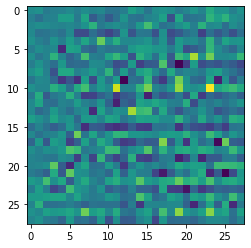

In [69]:
noise = tf.random.normal([1, 128]) # creating 1 randome sample of 100 dimension

# forward-pass through the generator 
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [73]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [74]:
discriminator = make_discriminator_model()
discriminator.summary()
# keras.utils.plot_model(discriminator, 'discriminator.png', show_shapes=True)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        4864      
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_17 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_8 (Flatten)         (None, 6272)            

In [75]:
decision = discriminator(generated_image) # forward-pass. model not yet trained
print (decision)

tf.Tensor([[-0.00173885]], shape=(1, 1), dtype=float32)


In [76]:
# Loss: Binary CrossEntropy <=> log-loss

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [77]:
# For the discrimanator,  0 => fake and 1 => real image
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # tf.ones creates a tensor of ones
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #tf.zeros creates a tensor of zeros
    total_loss = real_loss + fake_loss
    return total_loss

In [78]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [79]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [80]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator) # what objects to store in a ckpt

In [81]:


# We will reuse these test_random_vectors overtime (so it's easier)
# to visualize progress in the animated GIF)
test_random_vectors = tf.random.normal([num_examples_to_generate, noise_dim])
print(test_random_vectors.shape)

(16, 128)


In [82]:
 #Notice the use of `tf.function`
# This annotation causes the function to be "compiled" into a TF Graph
@tf.function 
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [83]:
def generate_and_save_images(model, epoch, test_input): #model is nothing but a genrator model
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5) # genrator image will be between [-1,1], hence here we are denormalizing the data
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [84]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             test_random_vectors)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           test_random_vectors)

In [85]:
train(train_dataset, EPOCHS)

ValueError: ignored